In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
# path_to_testfile = "./instances_v2/instances/fpg-poly_0000000020_h1.instance.json"
path_to_testfile = "./instances_v2/instances/socg60.instance.json"
#path_to_testfile = "../instances/fpg-poly_0000000020_h2.instance.json"

with open(path_to_testfile) as testfile:
    polygon = json.load(testfile)

In [3]:
print(polygon['type'])
print(polygon['name'])
print(polygon['n'])
print(polygon['outer_boundary'])
print(polygon['holes'])
print(len(polygon['holes']))


CGSHOP2023_Instance
socg60
60
[{'x': 112, 'y': 736}, {'x': 112, 'y': 704}, {'x': 144, 'y': 704}, {'x': 144, 'y': 672}, {'x': 109, 'y': 672}, {'x': 109, 'y': 704}, {'x': 64, 'y': 704}, {'x': 64, 'y': 672}, {'x': 16, 'y': 672}, {'x': 16, 'y': 640}, {'x': 64, 'y': 640}, {'x': 64, 'y': 624}, {'x': 16, 'y': 624}, {'x': 16, 'y': 592}, {'x': 64, 'y': 592}, {'x': 64, 'y': 560}, {'x': 109, 'y': 560}, {'x': 109, 'y': 592}, {'x': 144, 'y': 592}, {'x': 144, 'y': 560}, {'x': 112, 'y': 560}, {'x': 112, 'y': 528}, {'x': 144, 'y': 528}, {'x': 144, 'y': 480}, {'x': 176, 'y': 480}, {'x': 176, 'y': 528}, {'x': 192, 'y': 528}, {'x': 192, 'y': 480}, {'x': 224, 'y': 480}, {'x': 224, 'y': 528}, {'x': 256, 'y': 528}, {'x': 256, 'y': 560}, {'x': 224, 'y': 560}, {'x': 224, 'y': 592}, {'x': 259, 'y': 592}, {'x': 259, 'y': 560}, {'x': 304, 'y': 560}, {'x': 304, 'y': 592}, {'x': 352, 'y': 592}, {'x': 352, 'y': 624}, {'x': 304, 'y': 624}, {'x': 304, 'y': 640}, {'x': 352, 'y': 640}, {'x': 352, 'y': 672}, {'x': 304, 

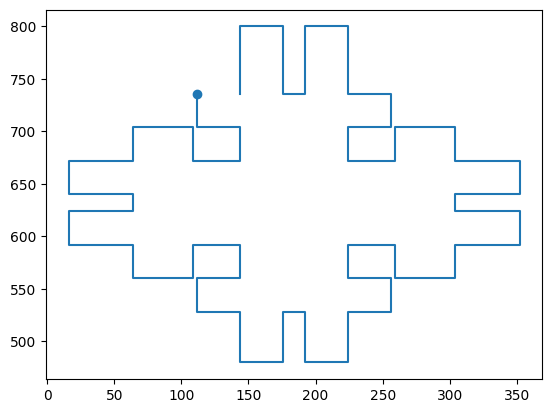

In [4]:
listpolygon = []
for pt in polygon['outer_boundary']:
    listpolygon.append([pt['x'], pt['y']])

listpolygon = np.array(listpolygon)

plt.plot(listpolygon.T[0], listpolygon.T[1])
# plt.scatter(listpolygon.T[0][1:], listpolygon.T[1][1:])
plt.scatter(listpolygon[0][0], listpolygon[0][1])

for hole in polygon['holes']:
    listhole = []
    for pt in hole:
        listhole.append([pt['x'], pt['y']])
    
    listhole = np.array(listhole)

    plt.plot(listhole.T[0], listhole.T[1])
    # plt.scatter(listhole.T[0][1:], listhole.T[1][1:])
    plt.scatter(listhole[0][0], listhole[0][1])

plt.show()



In [5]:
class Point:
    def __init__(self, x, y, parent, incoming, outgoing):
        self.coordinate = (x,y)
        self.parent = parent
        self.incoming = incoming
        self.outgoing = outgoing

class Edge:
    def __init__(self, pt1, pt2, parent):
        self.pt1 = pt1
        self.pt2 = pt2
        self.parent = parent

class Polygon:
    def __init__(self, isHole, points, edges, holes):
        self.isHole = isHole
        self.points = points
        self.edges = edges
        self.holes = holes

    def setholes(self, holes_new):
        self.holes = holes_new


In [6]:
#Creating outer boundary pts, edges, polygon
listpts = []
listpolygons = []
listedges = []

#Create points + Edges
for pt in polygon['outer_boundary']:
    (x,y) = [pt['x'], pt['y']]
    p = Point(x,y, None, None, None)
    listpts.append(p)

counter = 0
for pt in listpts:
    e = Edge(listpts[counter].coordinate, listpts[counter-1].coordinate, None)
    #print(listpts[counter].incoming, e, counter)
    listedges.append(e)
    counter +=1
    #listpts[counter].incoming = e

#Update adjacent edges
z = len(listpts)
for i in range(z):
    #print(listpts[i].coordinate, listedges[i].pt1, listedges[i].pt2)
    listpts[i].incoming = listedges[i]
    if i < z-1:
        listpts[i].outgoing = listedges[i+1]
    else:
        listpts[i].outgoing = listedges[0]

#Create polygon and update parent of points/vertices to be this polygon
poly = Polygon(0, listpts, listedges, None)
for edges in poly.edges:
    edges.parent = poly #Update edges parent
for pts in poly.points:
    pts.parent = poly #Update point parent

#Print checks to get items
#print(len(poly.edges), len(poly.points))
#for e in p.edges:
    #print(e.pt1, e.pt2, e.parent)
#for pts in p.points:
    #print(pts.coordinate, pts.parent, pts.incoming.pt1, pts.incoming.pt2, pts.outgoing.pt1, pts.outgoing.pt2)
#for e in h.edges:
    #print(e.pt1, e.pt2, e.parent)
#for pts in h.points:
    #print(pts.coordinate, pts.parent)
#print(p.edges)


In [7]:
#Do the same for holes
counter = 0
if len(polygon['holes']) == 0:
    ishole = 0
else:
    ishole = 1

#If we have holes, we are allowed to do this part    
if ishole:

    length_holes = len(polygon['holes'])
    listholeedges = [[]]*length_holes
    listholepts = [[]]*length_holes
    listholepolygons = []

    #We might get multiple holes, so 1 list per hole for the edges and points of a hole
    for ctr in range(length_holes):
        #print(ctr)
        
        #Points in hole
        for pt in polygon['holes'][ctr]:
            #print(pt)
            (x,y) = [pt['x'], pt['y']]
            #print((x,y))
            p = Point(x,y, None, None, None)
            #listpts.append(p) #Do we need this (hole pt into main point list)?
            listholepts[ctr].append(p)
            #print(listholepts[ctr])

        #Edges in hole
        counter = 0
        for pt in listholepts:
            e = Edge(listholepts[ctr][counter].coordinate, listholepts[ctr][counter-1].coordinate, None)
            #listedges.append(e) #Do we need this (hole edge into main edge list ?)
            listholeedges[ctr].append(e)
            counter +=1

        #adjacent edges of a point
        z = len(listholepts)
        for i in range(z):
            #print(listpts[i].coordinate, listedges[i].pt1, listedges[i].pt2)
            listholepts[ctr][i].incoming = listholeedges[ctr][i]
            #print(i, x)
            if i < z-1:
                listholepts[ctr][i].outgoing = listholeedges[ctr][i+1]
            else:
                listholepts[ctr][i].outgoing = listholeedges[ctr][0]
                
        counter = 0
        h = Polygon(1, listholepts[ctr], listholeedges[ctr], None)
        #Update all edges and points to make sure that the parent is set to this hole
        for edges in h.edges:
            edges.parent = h #Update edges parent
        for pts in h.points:
            pts.parent = h #Update point parent

        #append hole to list
        listholepolygons.append(h)
        #print("added", h, "in ctr", ctr)

        #Do we need to add all points and edges of holes in the main lists of them (so boundary pts/edges and those of the holes)
        #for item in listholepts:
        #    listpts.append(item)
        #for item2 in listholeedges:
        #    listedges.append(item2)
        
    #add all holes we created in the main polygon
    poly.setholes(listholepolygons)
    #print(poly.holes)

# Useful functions?

In [8]:
def pt2np(pt):
    return np.array([pt['x'], pt['y']])

In [9]:
#returns the orientation of p3 wrt line through p1 and p2
def orientation(p1, p2, p3):

    #vector from p1 to p2
    a = [(int(p2['x']) - int(p1['x'])), (int(p2['y']) - int(p1['y']))]
    #vector from p1 to p3
    b = [(int(p3['x']) - int(p1['x'])), (int(p3['y']) - int(p1['y']))]

    #cross product
    cross = int(a[0]) * int(b[1]) - int(a[1]) * int(b[0])

    if cross == 0: #colinear
        return 0
    else: #sign gives left or right of \bar{p1p2}
        return np.sign(cross)

In [10]:
def find_reflex(polygon):
    n = polygon['n']
    bdry = polygon['outer_boundary']
    holes = polygon['holes']
    count = 0
    reflex = []

    for i in range(len(bdry)):
        if orientation(bdry[(i-1)], bdry[i], bdry[(i+1) % len(bdry)]) == -1: reflex.append(bdry[i]); count += 1

    for hole in holes:
        for i in range(len(hole)):
            if orientation(hole[(i-1)], hole[i], hole[(i+1) % len(hole)]) == -1: reflex.append(hole[i]); count += 1

    return reflex, count

In [65]:
def onSegment(p1, p2, p3):
    if (( p2.coordinate[0] <= max(p1.coordinate[0], p3.coordinate[0])) and (p2.coordinate[0] >= min(p1.coordinate[0], p3.coordinate[0])) and (p2.coordinate[1] <= max(p1.coordinate[1], p3.coordinate[1])) and (p2.coordinate[1] >= min(p1.coordinate[1], p3.coordinate[1]))):
        return True
    return False

In [30]:
# # def status(polygon, v):
#     edges = []
#     status = []
#     answer = []
#     #find the incoming vertex of the reflex vertex also add all the edges in a list
#     for pt in range(len(polygon['outer_boundary'])):
#         if polygon['outer_boundary'][pt] == v:
#             print(polygon['outer_boundary'][pt])
#             incoming = polygon['outer_boundary'][pt - 1]
#             e = Edge(polygon['outer_boundary'][pt], polygon['outer_boundary'][pt + 1], None)
#             edges.append(e)
#     for pt in range(len(polygon['holes'])):
#         if polygon['holes'][pt] == v:
#             incoming = polygon['holes'][pt - 1]
#             e = Edge(polygon['holes'][pt], polygon['holes'][pt + 1], None)
#             edges.append(e)
#     #compute the slope of v and its incoming vertex        
#     #m1 = (int(v['y']) - int(incoming['y']))/(int(v['x']) - int(incoming['x']))
#     #create a new vertex v1
#     #v1 = Point(int(v['x'] * 100 * m1), int(v['y'] * 100 * m1), None, None, None) 
#     print(incoming)
#     print(len(edges))
#     #do orientation test between v, v1 and all edges to initialize the status
#     for i in range(len(edges)):
#         o1 = orientation(incoming, v, edges[i].pt1)
#         o2 = orientation(incoming, v, edges[i].pt2)
#         o3 = orientation(edges[i].pt1, edges[i].pt2, incoming)
#         o4 = orientation(edges[i].pt1, edges[i].pt2, v)

#         if ((o1 != o2) and (o3 != o4)):
#             status.append(edges[i])
        
#         if ((o1 == 0) and onSegment(incoming, v, edges[i].pt1)):
#             status.append(edges[i])
        
#         if ((o2 == 0) and onSegment(incoming, edges[i].pt2, edges[i].pt1)):
#             status.append(edges[i])
        
#         if ((o3 == 0) and onSegment(v, incoming, edges[i].pt2)):
#             status.append(edges[i])

#         if ((o4 == 0) and onSegment(v, edges[i].pt1, edges[i].pt2)):
#             status.append(edges[i])
    
#     return answer


In [64]:
def orientation_class(p1, p2, p3):

    #vector from p1 to p2
    a = [(int(p2.coordinate[0]) - int(p1.coordinate[0])), (int(p2.coordinate[1]) - int(p1.coordinate[1]))]
    #vector from p1 to p3
    b = [(int(p3.coordinate[0]) - int(p1.coordinate[0])), (int(p3.coordinate[1]) - int(p1.coordinate[1]))]

    #cross product
    cross = int(a[0]) * int(b[1]) - int(a[1]) * int(b[0])

    if cross == 0: #colinear
        return 0
    else: #sign gives left or right of \bar{p1p2}
        return np.sign(cross)

In [92]:
def status(v, polygon):
    pts = []
    edges = []
    status = []

    for pt in range(len(polygon['outer_boundary'])):
        if (polygon['outer_boundary'][pt] == v):
            incoming = polygon['outer_boundary'][pt - 1]
        (x,y) = [polygon['outer_boundary'][pt]['x'], polygon['outer_boundary'][pt]['y']]
        p = Point(x,y, None, None, None)
        pts.append(p)
    
    for hole in polygon['holes']:
        for i in range(len(hole)):
            if (polygon['holes'][hole][i] == v):
                incoming = polygon['holes'][hole][i - 1]
            (x,y) = [polygon['holes'][hole][i]['x'], polygon['holes'][hole][i]['y']]
            p = Point(x, y, None, None, None)
            pts.append(p)

    for i in range(len(pts)):
        e = Edge(pts[i].coordinate, pts[i-1].coordinate, None)
        edges.append(e)

    r = Point(v['x'], v['y'], None, None, None)
    incoming = Point(incoming['x'], incoming['y'], None, None, None)

    for i in range(len(pts)):
        o1 = orientation_class(incoming, r, pts[i])
        o2 = orientation_class(incoming, r, pts[i-1])
        o3 = orientation_class(pts[i], pts[i-1], incoming)
        o4 = orientation_class(pts[i], pts[i-1], r)

        if ((o1 != o2) and (o3 != o4)):
            e = Edge(pts[i - 1].coordinate, pts[i].coordinate, None)
            status.append(e)
        
        if ((o1 == 0) and onSegment(incoming, r, pts[i])):
            e = Edge(pts[i - 1].coordinate, pts[i].coordinate, None)
            status.append(e)
        
        if ((o2 == 0) and onSegment(incoming, pts[i], pts[i - 1])):
            e = Edge(pts[i - 1].coordinate, pts[i].coordinate, None)
            status.append(e)
        
        if ((o3 == 0) and onSegment(r, incoming, pts[i])):
            e = Edge(pts[i - 1].coordinate, pts[i].coordinate, None)
            status.append(e)

        if ((o4 == 0) and onSegment(r, pts[i-1], pts[i])):
            e = Edge(pts[i - 1].coordinate, pts[i].coordinate, None)
            status.append(e)

    return len(status)
    

In [13]:
def feasible(polygon, v):
    incoming = []
    outgoing = []
    region = []
    #check if the reflex vertex is on the boundary, if it is store its neighbors
    for pt in range(len(polygon['outer_boundary'])):
        if polygon['outer_boundary'][pt] == v:
            incoming.append(polygon['outer_boundary'][pt - 1])
            outgoing.append(polygon['outer_boundary'][pt + 1])
    #check if the reflex vertex is on a hole, if it is store its neighbors
    for pt in range(len(polygon['holes'])):
        if polygon['holes'][pt] == v:
            incoming.append(polygon['holes'][pt - 1])
            outgoing.append(polygon['holes'][pt + 1])
    #check the orientation with the supporting lines of v, if they are both equal to -1, then we add the point to the feasible region       
    for pt in range(len(polygon['holes'])):
            o1 = orientation(polygon['holes'][pt], incoming[0], v)
            o2 = orientation(v, outgoing[0], polygon['holes'][pt])
            if o1 == -1 and o2 == -1:
                region.append(polygon['holes'][pt])
    for pt in range(len(polygon['outer_boundary'])):
            o1 = orientation(polygon['outer_boundary'][pt], incoming[0], v)
            o2 = orientation(v, outgoing[0], polygon['outer_boundary'][pt])
            if o1 == -1 and o2 == -1:
                region.append(polygon['outer_boundary'][pt])
    return region


In [93]:
reflex, r = find_reflex(polygon)
#print(feasible(polygon, reflex[1]))
print(status(reflex[0], polygon))

16


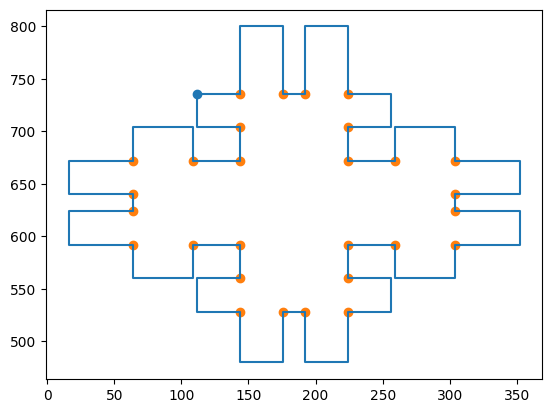

In [15]:
listpolygon = [[polygon['outer_boundary'][-1]['x'], polygon['outer_boundary'][-1]['y']]]
for pt in polygon['outer_boundary']:
    listpolygon.append([pt['x'], pt['y']])

listpolygon = np.array(listpolygon)

plt.plot(listpolygon.T[0], listpolygon.T[1])
# plt.scatter(listpolygon.T[0][1:], listpolygon.T[1][1:])
plt.scatter(listpolygon[1][0], listpolygon[1][1])

for hole in polygon['holes']:
    listhole = [[hole[-1]['x'], hole[-1]['y']]]
    for pt in hole:
        listhole.append([pt['x'], pt['y']])
    
    listhole = np.array(listhole)

    plt.plot(listhole.T[0], listhole.T[1])
    # plt.scatter(listhole.T[0][1:], listhole.T[1][1:])
    plt.scatter(listhole[1][0], listhole[1][1])

listreflex = []
for pt in reflex:
    listreflex.append([pt['x'], pt['y']])

listreflex = np.array(listreflex)

plt.scatter(listreflex.T[0], listreflex.T[1])

plt.show()